In [1]:
from datetime import timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf,pacf
import lightgbm as lgb
from  sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import optuna
from sklearn.preprocessing import PowerTransformer, LabelEncoder, MinMaxScaler
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
"""
class contains methods created to help in 
data loading ,exploration and basic transformation handling
Data transformation is not implemented with 
typical Pipeline/fit_transformed framework in mind as considered 
to be a work in progress 
"""
class HubwayTaskHelper:
    def __init__(self):
        self.raw_data = self.make_data()
        
        
    def get_lgbm_data(self) -> pd.DataFrame:
        lgbm_columns = ["duration", "start_date", "strt_statn","bike_nr", "subsc_type", "zip_code", "birth_date", "gender","municipal","HPCP","half_of_day", "hour", "start_week_day", "age"]
        return self.raw_data[lgbm_columns]
    

    def make_data(self) -> pd.DataFrame:
        #open files remove columns that are not needed
        df_rides = pd.read_csv("hubway_trips.csv")
        df_stations = pd.read_csv("hubway_stations.csv")
        df_weather = pd.read_csv("weather.csv")
        del df_rides["seq_id"]
        del df_rides["hubway_id"]
        del df_rides["status"]
        del df_rides["end_date"]
        del df_rides["end_statn"]
        
        #remove the target variable outliers
        df_rides.loc[df_rides["duration"]>df_rides["duration"].quantile(0.995), "duration"] = df_rides["duration"].quantile(0.995)
        df_rides = df_rides[df_rides["duration"]>0]
        df_rides = df_rides[df_rides["duration"]>df_rides["duration"].quantile(0.005)]
        
        #merge in stations data and drop data with stations that were removed
        df_rds_stn = df_rides.merge(df_stations, how='left', left_on='strt_statn', right_on='id', suffixes = ["_ride", "_station"] )
        df_rds_stn = df_rds_stn[df_rds_stn["status"]!="Removed"]
        
        
        #make start_date a datetime and truncate to hours
        df_rds_stn["start_date"] = pd.to_datetime(df_rds_stn["start_date"])
        df_rds_stn["start_date_hrs"] =  df_rds_stn["start_date"].dt.floor('H')

        #make date a datetime, add Boston colusmn so it can be merged to only Boston stations
        df_weather["DATE"] = pd.to_datetime(df_weather["DATE"])
        df_weather["Boston"] = "Boston"
        df_rds_stn = df_rds_stn.merge(df_weather, how='left', left_on = ["municipal","start_date_hrs"], right_on = ['Boston',"DATE"])
        
        #as per documentation, if no data in weather and Boston, then 0 HPCP
        df_rds_stn.loc[df_rds_stn["municipal"] =='Boston' ]["HPCP"] = df_rds_stn.loc[df_rds_stn["municipal"] =='Boston']["HPCP"].fillna(0)
        
        #make basic time related features
        df_rds_stn["hour"] = df_rds_stn["start_date"].dt.hour
        df_rds_stn["start_week_day"] = df_rds_stn["start_date"].dt.dayofweek
        df_rds_stn["half_of_day"] = np.ceil(df_rds_stn["start_date"].dt.hour/12)
        df_rds_stn["half_of_day"].replace([0], 1, inplace = True)
        df_rds_stn["half_of_day"] = df_rds_stn["half_of_day"].astype(int).astype(str)
        
        #make age out of birth day and fill categorical variables with 'na' if no data
        df_rds_stn["age"] = df_rds_stn["birth_date"].apply(lambda x: 2014 - int(x) if str(x) != 'nan' else np.nan)
        df_rds_stn[["bike_nr","gender", "zip_code","strt_statn"]] = df_rds_stn[["bike_nr","gender", "zip_code","strt_statn"]].fillna('na')
        return df_rds_stn
         
    @staticmethod
    def group_plot(df_rds_stn: pd.DataFrame, col_interest: str) -> None:
        plt.figure(figsize=(7, 4))
        df_rds_stn[col_interest] = df_rds_stn[col_interest].astype('category')
        groupped_col_dur = df_rds_stn.groupby(col_interest)["duration"].median().reset_index().sort_values(col_interest, ascending=False)

        sorted_list = groupped_col_dur.sort_values("duration", ascending=False)[col_interest].tolist()
        ax = sns.boxplot(y="duration", x=col_interest, data=df_rds_stn, order= sorted_list)
        ax.set_title(col_interest)
        ax.set(ylim=(-5, 3000))
    
    @staticmethod
    def reg_plot(df_rds_stn: pd.DataFrame, col_interest: str) -> None:
        plt.figure(figsize=(7, 4))
        ax = sns.scatterplot(data=df_rds_stn[["duration", col_interest]], x="duration", y=col_interest,)
        plt.plot()

        
    @staticmethod    
    def plot_timeseries(df_rds_stn: pd.DataFrame, municipal:str) -> None:
        plt.figure(figsize=(10, 3))
        if municipal == 'None':
            df_rds_stn = df_rds_stn[df_rds_stn["municipal"]==municipal]
        df_rds_stn["date_day"] = df_rds_stn["start_date"].dt.floor("D")
        groupped_col_dur = df_rds_stn.groupby('date_day')["duration"].median()
        sns.lineplot(data = groupped_col_dur)
    
    @staticmethod
    def plot_autocorrs(df_rds_stn: pd.DataFrame, municipal: str) -> None:
        if municipal:
            print ("done")
        df_rds_stn["date_day"] = df_rds_stn["start_date"].dt.floor("D")
        acf(df_rds_stn['duration'])
        pacf(df_rds_stn['duration'])

    @staticmethod
    def bin_age(df: pd.DataFrame) -> pd.DataFrame:
        def _map_age_to_bin(x: int):
            bins = {
                (0,20):"0 to 20",
                (21,25) : "21 to 25",
                (26,30) : "26 to 30",
                (31,35) : "31 to 35",
                (36,40) : "36 to 40",
                (41,45) : "41 to 45",
                (46,50) : "46 to 50",
                (51,56) : "51 to 56",
                (56,60) : "56 to 60",
                (61,66) : "61 to 66",
                (66,150) : "66 onwards",
            }
            bin_value = 'n/a'
            for i, k in bins.items():
                if str(x) != 'n/a' and i[0] <= x and i[1] >= x:
                    bin_value = k
            return bin_value
        df["age_bin"] = df["age"].apply(_map_age_to_bin)
        del df["age"]
        return df
        
           
    def get_months(self, df: pd.DataFrame) -> pd.DataFrame:
        df["start_month"] =  df["start_date"].dt.to_period('M').dt.to_timestamp()
        return df

    def start_or_ongoing(self, df: pd.DataFrame) -> pd.DataFrame:
        df["year"] = df["start_date"].dt.to_period('Y').dt.to_timestamp().astype(str)
        df["start_ongoing"] = df[['year', 'municipal']].apply(lambda x : "start" if (x[0] =='2011-01-01' and x[1] == 'Boston') or (x[0] =='2012-01-01' and x[1] != 'Boston') else "ongoing", axis=1) 
        del df["year"]
        return df

    def features_week_ago(self, df: pd.DataFrame) -> pd.DataFrame:
        df["start_day"] = df["start_date"].dt.floor("D")
        df["start_day_-7"] = df["start_day"] + timedelta(days=-7)
        df_groupped = df.groupby(["municipal", "start_day_-7"])[["duration", "HPCP"]].mean().reset_index()
        df_groupped.columns = ["municipal", "start_day", "duration_week_ago", "HPCP_week_ago"]
        df = df.merge(df_groupped, how='left', on=["municipal", "start_day"])
        del df["start_day_-7"]
        return df
 
    def features_week_ago_half_day(self, df: pd.DataFrame) -> pd.DataFrame:
        df["start_day"] = df["start_date"].dt.floor("D")
        df["start_day_-7"] = df["start_day"] + timedelta(days=-7)
        df_groupped = df.groupby(["municipal", "start_day_-7", "half_of_day"])[["duration", "HPCP"]].mean().reset_index()
        df_groupped.columns = ["municipal", "start_day", "half_of_day", "duration_week_ago_half_day", "HPCP_week_ago_half_day"]
        df = df.merge(df_groupped, how='left', on=["municipal", "start_day", "half_of_day"])
        del df["start_day_-7"]
        return df    

    def features_three_previous_days(self, df: pd.DataFrame) -> pd.DataFrame:
        df["start_day"] = df["start_date"].dt.floor("D")
        for lag in range(1,4):            
            df[f"start_day_-{lag}"] = df["start_day"] + timedelta(days=-lag)
            df_groupped = df.groupby(["municipal", f"start_day_-{lag}", "half_of_day"])[[f"duration", f"HPCP"]].mean().reset_index()
            df_groupped.columns = ["municipal", "start_day", "half_of_day", f"duration_{lag}_lag_d_half_day", f"HPCP_{lag}_lag_d_half_day"]
            df = df.merge(df_groupped, how='left', on=["municipal", "start_day", "half_of_day"])
        del df["start_day"]
        return df     

    def features_last_week(self, df: pd.DataFrame) -> pd.DataFrame:
        df["start_week"] =  df["start_date"].dt.to_period('W').dt.to_timestamp()
        for lag in range(1,2):            
            df[f"start_week_-{lag}"] = df["start_week"] + timedelta(weeks=-lag)
            df_groupped = df.groupby(["municipal", f"start_week_-{lag}"])[[f"duration", f"HPCP"]].mean().reset_index()
            df_groupped.columns = ["municipal", "start_week", f"duration_{lag}_lag_W", f"HPCP_{lag}_lag_W"]
            df = df.merge(df_groupped, how='left', on=["municipal", "start_week"])
        del df["start_week"]
        return df   

    def features_last_week_half_day(self, df: pd.DataFrame) -> pd.DataFrame:
        df["start_week"] =  df["start_date"].dt.to_period('W').dt.to_timestamp()
        for lag in range(1,2):            
            df[f"start_week_-{lag}"] = df["start_week"] + timedelta(weeks=-lag)
            df_groupped = df.groupby(["municipal", f"start_week_-{lag}", "half_of_day"])[[f"duration", f"HPCP"]].mean().reset_index()
            df_groupped.columns = ["municipal", "start_week", "half_of_day", f"duration_{lag}_lag_W_half_day", f"HPCP_{lag}_lag_W_half_day"]
            df = df.merge(df_groupped, how='left', on=["municipal", "start_week", "half_of_day"])
        del df["start_week"]
        return df  
               
    def make_features(self) -> pd.DataFrame:
        df = self.get_lgbm_data()
        df = self.features_week_ago(df)
        df = self.features_week_ago_half_day(df)
        df = self.features_three_previous_days(df)
        df = self.features_last_week(df)
        df = self.features_last_week_half_day(df)
        df = self.get_months(df)
        df = self.start_or_ongoing(df)
        return df
        

In [5]:

wdh = HubwayTaskHelper()
#data = wdh.get_lgbm_data()
data_ready = wdh.make_features()

In [6]:
#basic data preparation for feeding into model
categorical_feats = [
             'strt_statn',
             'bike_nr',
             'subsc_type',
             'zip_code',
             'gender',
             'municipal',
             'start_week_day',
             'start_month',
             'start_ongoing'
]


numerical_feats= [
             'HPCP',
              'age',
             'hour',
             'duration_week_ago',
             'HPCP_week_ago',
             'duration_week_ago_half_day',
             'duration_1_lag_d_half_day',
             'HPCP_1_lag_d_half_day',
             'duration_2_lag_d_half_day',
             'HPCP_2_lag_d_half_day',
             'duration_3_lag_d_half_day',
             'HPCP_3_lag_d_half_day',
             'duration_1_lag_W',
             'HPCP_1_lag_W',
             'duration_1_lag_W_half_day',
]


pt = PowerTransformer()
y = pt.fit_transform(data_ready[["duration"]])

X = data_ready[categorical_feats + numerical_feats]

#these two columns need to be encoded as LGBM cant handle prediod/datetime objects
cat_cols_to_encode = ["start_week_day", "start_month"]
lencoders = {}
for i in cat_cols_to_encode:
    encoder = LabelEncoder()
    X[i] = encoder.fit_transform(X[i])
    lencoders[i] = encoder
    

X[categorical_feats] = X[categorical_feats].astype('category')

#x_train_and_eval will be further split into test and eval sets
x_train_and_eval, x_test, y_train_and_eval, y_test =  train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# hyperparametr search
def objective(trial,data=x_train_and_eval,target=y_train_and_eval):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
         'random_state': 42,
         'n_estimators': trial.suggest_int('n_estimators',100,10000),
         'max_depth': trial.suggest_int('max_depth', 2,20),
         'num_leaves' : trial.suggest_int('num_leaves', 6, 400),
         'learning_rate': trial.suggest_categorical('learning_rate', [0.001,0.005,0.01,0.03,0.05,0.1,0.3]),
         'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 20, 1000),
         'max_bin': trial.suggest_int('max_bin',25,500),
         'feature_fraction': trial.suggest_categorical('feature_fraction', [0.5,0.7,0.9]),
         'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y.reshape([-1]).tolist(),eval_set=[(test_x,test_y.reshape([-1]).tolist())],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-07-31 23:07:29,789] A new study created in memory with name: no-name-ccf20bc2-9507-4843-85ee-9c3d2891a2a8
[I 2022-07-31 23:16:29,225] Trial 0 finished with value: 0.8167434108730302 and parameters: {'n_estimators': 8142, 'max_depth': 5, 'num_leaves': 226, 'learning_rate': 0.005, 'min_data_in_leaf': 501, 'max_bin': 338, 'feature_fraction': 0.7, 'subsample': 0.8}. Best is trial 0 with value: 0.8167434108730302.
[I 2022-07-31 23:17:14,954] Trial 1 finished with value: 0.8179097884885308 and parameters: {'n_estimators': 6006, 'max_depth': 3, 'num_leaves': 325, 'learning_rate': 0.1, 'min_data_in_leaf': 491, 'max_bin': 312, 'feature_fraction': 0.9, 'subsample': 0.4}. Best is trial 0 with value: 0.8167434108730302.
[I 2022-07-31 23:19:52,927] Trial 2 finished with value: 0.8061281643223492 and parameters: {'n_estimators': 9623, 'max_depth': 18, 'num_leaves': 149, 'learning_rate': 0.03, 'min_data_in_leaf': 539, 'max_bin': 379, 'feature_fraction': 0.9, 'subsample': 0.4}. Best is trial 2

[I 2022-08-01 01:13:15,931] Trial 26 finished with value: 0.7959544388784374 and parameters: {'n_estimators': 7624, 'max_depth': 19, 'num_leaves': 100, 'learning_rate': 0.03, 'min_data_in_leaf': 133, 'max_bin': 493, 'feature_fraction': 0.5, 'subsample': 0.8}. Best is trial 11 with value: 0.794281959571894.
[I 2022-08-01 01:17:10,884] Trial 27 finished with value: 0.8053478554593685 and parameters: {'n_estimators': 6140, 'max_depth': 19, 'num_leaves': 22, 'learning_rate': 0.03, 'min_data_in_leaf': 229, 'max_bin': 419, 'feature_fraction': 0.5, 'subsample': 0.8}. Best is trial 11 with value: 0.794281959571894.
[I 2022-08-01 01:19:29,028] Trial 28 finished with value: 0.8095137856110725 and parameters: {'n_estimators': 9060, 'max_depth': 17, 'num_leaves': 67, 'learning_rate': 0.03, 'min_data_in_leaf': 93, 'max_bin': 464, 'feature_fraction': 0.9, 'subsample': 0.8}. Best is trial 11 with value: 0.794281959571894.
[I 2022-08-01 01:32:53,274] Trial 29 finished with value: 0.8057050916807117 an

Number of finished trials: 50
Best trial: {'n_estimators': 7094, 'max_depth': 14, 'num_leaves': 195, 'learning_rate': 0.03, 'min_data_in_leaf': 83, 'max_bin': 447, 'feature_fraction': 0.5, 'subsample': 0.7}


In [7]:
x_train, x_eval, y_train, y_eval =  train_test_split(x_train_and_eval, y_train_and_eval, test_size=0.1, random_state=42)
eval_data = [(x_eval, y_eval.reshape([-1]))]

lgbm = lgb.LGBMRegressor(n_estimators = 7094, 
                  max_depth = 14, 
                  num_leaves= 195, 
                  learning_rate = 0.03,
                 min_data_in_leaf=83,
                 max_bin=447,
                 feature_fraction = 0.5,
                 subsample = 0.7,
                 evaluation_metric = 'rmse',

                 random_state=42)
lgbm.fit(x_train,
         y_train.reshape([-1]), 
         eval_set = eval_data, 
         early_stopping_rounds=100,
        categorical_feature = categorical_feats)

[1]	valid_0's l2: 0.984754
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.970929
[3]	valid_0's l2: 0.959285
[4]	valid_0's l2: 0.946923
[5]	valid_0's l2: 0.935499
[6]	valid_0's l2: 0.931952
[7]	valid_0's l2: 0.921416
[8]	valid_0's l2: 0.91246
[9]	valid_0's l2: 0.903208
[10]	valid_0's l2: 0.89159
[11]	valid_0's l2: 0.882292
[12]	valid_0's l2: 0.873699
[13]	valid_0's l2: 0.865711
[14]	valid_0's l2: 0.859277
[15]	valid_0's l2: 0.85362
[16]	valid_0's l2: 0.850133
[17]	valid_0's l2: 0.843669
[18]	valid_0's l2: 0.835521
[19]	valid_0's l2: 0.827526
[20]	valid_0's l2: 0.821755
[21]	valid_0's l2: 0.817006
[22]	valid_0's l2: 0.809971
[23]	valid_0's l2: 0.806366
[24]	valid_0's l2: 0.803258
[25]	valid_0's l2: 0.800321
[26]	valid_0's l2: 0.796474
[27]	valid_0's l2: 0.79329
[28]	valid_0's l2: 0.78903
[29]	valid_0's l2: 0.785229
[30]	valid_0's l2: 0.782404
[31]	valid_0's l2: 0.778907
[32]	valid_0's l2: 0.77547
[33]	valid_0's l2: 0.770642
[34]	valid_0's l2: 0.767724
[

[287]	valid_0's l2: 0.660004
[288]	valid_0's l2: 0.659978
[289]	valid_0's l2: 0.659969
[290]	valid_0's l2: 0.65993
[291]	valid_0's l2: 0.659562
[292]	valid_0's l2: 0.659486
[293]	valid_0's l2: 0.659419
[294]	valid_0's l2: 0.659347
[295]	valid_0's l2: 0.659256
[296]	valid_0's l2: 0.659156
[297]	valid_0's l2: 0.659119
[298]	valid_0's l2: 0.659139
[299]	valid_0's l2: 0.659052
[300]	valid_0's l2: 0.658776
[301]	valid_0's l2: 0.658734
[302]	valid_0's l2: 0.658732
[303]	valid_0's l2: 0.658607
[304]	valid_0's l2: 0.65862
[305]	valid_0's l2: 0.658584
[306]	valid_0's l2: 0.658594
[307]	valid_0's l2: 0.658558
[308]	valid_0's l2: 0.658559
[309]	valid_0's l2: 0.658353
[310]	valid_0's l2: 0.658349
[311]	valid_0's l2: 0.658364
[312]	valid_0's l2: 0.658379
[313]	valid_0's l2: 0.658339
[314]	valid_0's l2: 0.658048
[315]	valid_0's l2: 0.658041
[316]	valid_0's l2: 0.657977
[317]	valid_0's l2: 0.657925
[318]	valid_0's l2: 0.657914
[319]	valid_0's l2: 0.657863
[320]	valid_0's l2: 0.657864
[321]	valid_0's 

[570]	valid_0's l2: 0.649778
[571]	valid_0's l2: 0.649753
[572]	valid_0's l2: 0.649757
[573]	valid_0's l2: 0.649665
[574]	valid_0's l2: 0.64966
[575]	valid_0's l2: 0.649655
[576]	valid_0's l2: 0.649661
[577]	valid_0's l2: 0.649636
[578]	valid_0's l2: 0.649623
[579]	valid_0's l2: 0.649594
[580]	valid_0's l2: 0.649543
[581]	valid_0's l2: 0.649448
[582]	valid_0's l2: 0.649378
[583]	valid_0's l2: 0.649314
[584]	valid_0's l2: 0.649266
[585]	valid_0's l2: 0.649269
[586]	valid_0's l2: 0.649243
[587]	valid_0's l2: 0.649215
[588]	valid_0's l2: 0.649213
[589]	valid_0's l2: 0.649208
[590]	valid_0's l2: 0.649191
[591]	valid_0's l2: 0.649189
[592]	valid_0's l2: 0.649157
[593]	valid_0's l2: 0.649152
[594]	valid_0's l2: 0.649122
[595]	valid_0's l2: 0.649122
[596]	valid_0's l2: 0.649119
[597]	valid_0's l2: 0.64911
[598]	valid_0's l2: 0.649107
[599]	valid_0's l2: 0.649111
[600]	valid_0's l2: 0.649112
[601]	valid_0's l2: 0.649097
[602]	valid_0's l2: 0.649115
[603]	valid_0's l2: 0.649115
[604]	valid_0's 

[856]	valid_0's l2: 0.643566
[857]	valid_0's l2: 0.643572
[858]	valid_0's l2: 0.643581
[859]	valid_0's l2: 0.643582
[860]	valid_0's l2: 0.643546
[861]	valid_0's l2: 0.643536
[862]	valid_0's l2: 0.643526
[863]	valid_0's l2: 0.643517
[864]	valid_0's l2: 0.643505
[865]	valid_0's l2: 0.643499
[866]	valid_0's l2: 0.643499
[867]	valid_0's l2: 0.643496
[868]	valid_0's l2: 0.643479
[869]	valid_0's l2: 0.64348
[870]	valid_0's l2: 0.64345
[871]	valid_0's l2: 0.643411
[872]	valid_0's l2: 0.643275
[873]	valid_0's l2: 0.643271
[874]	valid_0's l2: 0.64326
[875]	valid_0's l2: 0.643263
[876]	valid_0's l2: 0.643255
[877]	valid_0's l2: 0.643255
[878]	valid_0's l2: 0.643099
[879]	valid_0's l2: 0.643095
[880]	valid_0's l2: 0.643109
[881]	valid_0's l2: 0.643106
[882]	valid_0's l2: 0.6431
[883]	valid_0's l2: 0.643086
[884]	valid_0's l2: 0.643097
[885]	valid_0's l2: 0.643096
[886]	valid_0's l2: 0.643096
[887]	valid_0's l2: 0.643099
[888]	valid_0's l2: 0.643027
[889]	valid_0's l2: 0.643029
[890]	valid_0's l2:

[1137]	valid_0's l2: 0.639485
[1138]	valid_0's l2: 0.639491
[1139]	valid_0's l2: 0.639496
[1140]	valid_0's l2: 0.639497
[1141]	valid_0's l2: 0.639504
[1142]	valid_0's l2: 0.639505
[1143]	valid_0's l2: 0.63951
[1144]	valid_0's l2: 0.639494
[1145]	valid_0's l2: 0.639485
[1146]	valid_0's l2: 0.639504
[1147]	valid_0's l2: 0.639517
[1148]	valid_0's l2: 0.639516
[1149]	valid_0's l2: 0.639505
[1150]	valid_0's l2: 0.639509
[1151]	valid_0's l2: 0.639517
[1152]	valid_0's l2: 0.63953
[1153]	valid_0's l2: 0.639529
[1154]	valid_0's l2: 0.639525
[1155]	valid_0's l2: 0.639522
[1156]	valid_0's l2: 0.639514
[1157]	valid_0's l2: 0.639488
[1158]	valid_0's l2: 0.63948
[1159]	valid_0's l2: 0.639478
[1160]	valid_0's l2: 0.639482
[1161]	valid_0's l2: 0.639497
[1162]	valid_0's l2: 0.639488
[1163]	valid_0's l2: 0.63943
[1164]	valid_0's l2: 0.639434
[1165]	valid_0's l2: 0.639439
[1166]	valid_0's l2: 0.639445
[1167]	valid_0's l2: 0.639431
[1168]	valid_0's l2: 0.639383
[1169]	valid_0's l2: 0.639166
[1170]	valid_0

[1412]	valid_0's l2: 0.63627
[1413]	valid_0's l2: 0.636235
[1414]	valid_0's l2: 0.636227
[1415]	valid_0's l2: 0.636216
[1416]	valid_0's l2: 0.636157
[1417]	valid_0's l2: 0.636162
[1418]	valid_0's l2: 0.636172
[1419]	valid_0's l2: 0.636177
[1420]	valid_0's l2: 0.636179
[1421]	valid_0's l2: 0.636169
[1422]	valid_0's l2: 0.636169
[1423]	valid_0's l2: 0.636167
[1424]	valid_0's l2: 0.636169
[1425]	valid_0's l2: 0.636172
[1426]	valid_0's l2: 0.63617
[1427]	valid_0's l2: 0.63616
[1428]	valid_0's l2: 0.636151
[1429]	valid_0's l2: 0.63615
[1430]	valid_0's l2: 0.636157
[1431]	valid_0's l2: 0.636142
[1432]	valid_0's l2: 0.63614
[1433]	valid_0's l2: 0.636141
[1434]	valid_0's l2: 0.636129
[1435]	valid_0's l2: 0.636137
[1436]	valid_0's l2: 0.636153
[1437]	valid_0's l2: 0.636131
[1438]	valid_0's l2: 0.636131
[1439]	valid_0's l2: 0.636121
[1440]	valid_0's l2: 0.636125
[1441]	valid_0's l2: 0.636106
[1442]	valid_0's l2: 0.636109
[1443]	valid_0's l2: 0.63611
[1444]	valid_0's l2: 0.636103
[1445]	valid_0's

[1689]	valid_0's l2: 0.634302
[1690]	valid_0's l2: 0.634302
[1691]	valid_0's l2: 0.634291
[1692]	valid_0's l2: 0.634274
[1693]	valid_0's l2: 0.634276
[1694]	valid_0's l2: 0.634284
[1695]	valid_0's l2: 0.634264
[1696]	valid_0's l2: 0.63426
[1697]	valid_0's l2: 0.634263
[1698]	valid_0's l2: 0.634258
[1699]	valid_0's l2: 0.634201
[1700]	valid_0's l2: 0.634181
[1701]	valid_0's l2: 0.63418
[1702]	valid_0's l2: 0.634182
[1703]	valid_0's l2: 0.634182
[1704]	valid_0's l2: 0.634163
[1705]	valid_0's l2: 0.634119
[1706]	valid_0's l2: 0.634088
[1707]	valid_0's l2: 0.634086
[1708]	valid_0's l2: 0.634084
[1709]	valid_0's l2: 0.634083
[1710]	valid_0's l2: 0.63407
[1711]	valid_0's l2: 0.634071
[1712]	valid_0's l2: 0.634058
[1713]	valid_0's l2: 0.634058
[1714]	valid_0's l2: 0.634063
[1715]	valid_0's l2: 0.634069
[1716]	valid_0's l2: 0.633986
[1717]	valid_0's l2: 0.633975
[1718]	valid_0's l2: 0.633978
[1719]	valid_0's l2: 0.63397
[1720]	valid_0's l2: 0.633973
[1721]	valid_0's l2: 0.633977
[1722]	valid_0

[1966]	valid_0's l2: 0.632491
[1967]	valid_0's l2: 0.632493
[1968]	valid_0's l2: 0.632479
[1969]	valid_0's l2: 0.632472
[1970]	valid_0's l2: 0.632472
[1971]	valid_0's l2: 0.632476
[1972]	valid_0's l2: 0.632456
[1973]	valid_0's l2: 0.632463
[1974]	valid_0's l2: 0.632429
[1975]	valid_0's l2: 0.632421
[1976]	valid_0's l2: 0.632405
[1977]	valid_0's l2: 0.632404
[1978]	valid_0's l2: 0.632399
[1979]	valid_0's l2: 0.632394
[1980]	valid_0's l2: 0.632393
[1981]	valid_0's l2: 0.632388
[1982]	valid_0's l2: 0.632393
[1983]	valid_0's l2: 0.632392
[1984]	valid_0's l2: 0.632391
[1985]	valid_0's l2: 0.632348
[1986]	valid_0's l2: 0.632345
[1987]	valid_0's l2: 0.632336
[1988]	valid_0's l2: 0.632335
[1989]	valid_0's l2: 0.632325
[1990]	valid_0's l2: 0.632327
[1991]	valid_0's l2: 0.632323
[1992]	valid_0's l2: 0.632317
[1993]	valid_0's l2: 0.632323
[1994]	valid_0's l2: 0.632318
[1995]	valid_0's l2: 0.632312
[1996]	valid_0's l2: 0.632316
[1997]	valid_0's l2: 0.632294
[1998]	valid_0's l2: 0.632295
[1999]	val

[2240]	valid_0's l2: 0.630927
[2241]	valid_0's l2: 0.630924
[2242]	valid_0's l2: 0.630924
[2243]	valid_0's l2: 0.630908
[2244]	valid_0's l2: 0.630908
[2245]	valid_0's l2: 0.630909
[2246]	valid_0's l2: 0.630921
[2247]	valid_0's l2: 0.630914
[2248]	valid_0's l2: 0.630907
[2249]	valid_0's l2: 0.630906
[2250]	valid_0's l2: 0.630913
[2251]	valid_0's l2: 0.630916
[2252]	valid_0's l2: 0.63091
[2253]	valid_0's l2: 0.630886
[2254]	valid_0's l2: 0.630891
[2255]	valid_0's l2: 0.630896
[2256]	valid_0's l2: 0.630892
[2257]	valid_0's l2: 0.630915
[2258]	valid_0's l2: 0.630914
[2259]	valid_0's l2: 0.630913
[2260]	valid_0's l2: 0.630915
[2261]	valid_0's l2: 0.630904
[2262]	valid_0's l2: 0.630899
[2263]	valid_0's l2: 0.630874
[2264]	valid_0's l2: 0.63087
[2265]	valid_0's l2: 0.630856
[2266]	valid_0's l2: 0.630818
[2267]	valid_0's l2: 0.630819
[2268]	valid_0's l2: 0.630794
[2269]	valid_0's l2: 0.630787
[2270]	valid_0's l2: 0.630788
[2271]	valid_0's l2: 0.630794
[2272]	valid_0's l2: 0.630798
[2273]	valid

[2518]	valid_0's l2: 0.629957
[2519]	valid_0's l2: 0.629954
[2520]	valid_0's l2: 0.629921
[2521]	valid_0's l2: 0.629923
[2522]	valid_0's l2: 0.629918
[2523]	valid_0's l2: 0.629917
[2524]	valid_0's l2: 0.629915
[2525]	valid_0's l2: 0.629917
[2526]	valid_0's l2: 0.629918
[2527]	valid_0's l2: 0.629914
[2528]	valid_0's l2: 0.629878
[2529]	valid_0's l2: 0.629883
[2530]	valid_0's l2: 0.629878
[2531]	valid_0's l2: 0.629875
[2532]	valid_0's l2: 0.629874
[2533]	valid_0's l2: 0.629877
[2534]	valid_0's l2: 0.629885
[2535]	valid_0's l2: 0.629892
[2536]	valid_0's l2: 0.629895
[2537]	valid_0's l2: 0.62989
[2538]	valid_0's l2: 0.629892
[2539]	valid_0's l2: 0.629892
[2540]	valid_0's l2: 0.62987
[2541]	valid_0's l2: 0.629868
[2542]	valid_0's l2: 0.629864
[2543]	valid_0's l2: 0.62985
[2544]	valid_0's l2: 0.629851
[2545]	valid_0's l2: 0.62985
[2546]	valid_0's l2: 0.629828
[2547]	valid_0's l2: 0.629822
[2548]	valid_0's l2: 0.629821
[2549]	valid_0's l2: 0.629823
[2550]	valid_0's l2: 0.629822
[2551]	valid_0

[2792]	valid_0's l2: 0.628716
[2793]	valid_0's l2: 0.628716
[2794]	valid_0's l2: 0.628715
[2795]	valid_0's l2: 0.628724
[2796]	valid_0's l2: 0.628736
[2797]	valid_0's l2: 0.628731
[2798]	valid_0's l2: 0.628725
[2799]	valid_0's l2: 0.628721
[2800]	valid_0's l2: 0.628719
[2801]	valid_0's l2: 0.628714
[2802]	valid_0's l2: 0.628714
[2803]	valid_0's l2: 0.628708
[2804]	valid_0's l2: 0.628688
[2805]	valid_0's l2: 0.628687
[2806]	valid_0's l2: 0.628694
[2807]	valid_0's l2: 0.628692
[2808]	valid_0's l2: 0.628692
[2809]	valid_0's l2: 0.628688
[2810]	valid_0's l2: 0.628692
[2811]	valid_0's l2: 0.628692
[2812]	valid_0's l2: 0.628684
[2813]	valid_0's l2: 0.62868
[2814]	valid_0's l2: 0.628681
[2815]	valid_0's l2: 0.628679
[2816]	valid_0's l2: 0.628682
[2817]	valid_0's l2: 0.628682
[2818]	valid_0's l2: 0.628682
[2819]	valid_0's l2: 0.628685
[2820]	valid_0's l2: 0.628682
[2821]	valid_0's l2: 0.628646
[2822]	valid_0's l2: 0.628611
[2823]	valid_0's l2: 0.628606
[2824]	valid_0's l2: 0.628604
[2825]	vali

[3069]	valid_0's l2: 0.628087
[3070]	valid_0's l2: 0.628079
[3071]	valid_0's l2: 0.628075
[3072]	valid_0's l2: 0.628085
[3073]	valid_0's l2: 0.628087
[3074]	valid_0's l2: 0.628079
[3075]	valid_0's l2: 0.628082
[3076]	valid_0's l2: 0.628079
[3077]	valid_0's l2: 0.628086
[3078]	valid_0's l2: 0.628082
[3079]	valid_0's l2: 0.62808
[3080]	valid_0's l2: 0.628082
[3081]	valid_0's l2: 0.628083
[3082]	valid_0's l2: 0.628074
[3083]	valid_0's l2: 0.62808
[3084]	valid_0's l2: 0.628085
[3085]	valid_0's l2: 0.628086
[3086]	valid_0's l2: 0.628086
[3087]	valid_0's l2: 0.62809
[3088]	valid_0's l2: 0.628073
[3089]	valid_0's l2: 0.628068
[3090]	valid_0's l2: 0.628064
[3091]	valid_0's l2: 0.628058
[3092]	valid_0's l2: 0.628066
[3093]	valid_0's l2: 0.628066
[3094]	valid_0's l2: 0.628056
[3095]	valid_0's l2: 0.628046
[3096]	valid_0's l2: 0.628054
[3097]	valid_0's l2: 0.62806
[3098]	valid_0's l2: 0.628066
[3099]	valid_0's l2: 0.628065
[3100]	valid_0's l2: 0.628069
[3101]	valid_0's l2: 0.628065
[3102]	valid_0

[3345]	valid_0's l2: 0.627546
[3346]	valid_0's l2: 0.627548
[3347]	valid_0's l2: 0.627538
[3348]	valid_0's l2: 0.627543
[3349]	valid_0's l2: 0.627532
[3350]	valid_0's l2: 0.627535
[3351]	valid_0's l2: 0.627538
[3352]	valid_0's l2: 0.627529
[3353]	valid_0's l2: 0.627528
[3354]	valid_0's l2: 0.627525
[3355]	valid_0's l2: 0.627525
[3356]	valid_0's l2: 0.627534
[3357]	valid_0's l2: 0.627521
[3358]	valid_0's l2: 0.627523
[3359]	valid_0's l2: 0.627517
[3360]	valid_0's l2: 0.627499
[3361]	valid_0's l2: 0.627494
[3362]	valid_0's l2: 0.627502
[3363]	valid_0's l2: 0.627502
[3364]	valid_0's l2: 0.627502
[3365]	valid_0's l2: 0.627502
[3366]	valid_0's l2: 0.627497
[3367]	valid_0's l2: 0.627502
[3368]	valid_0's l2: 0.6275
[3369]	valid_0's l2: 0.627503
[3370]	valid_0's l2: 0.627484
[3371]	valid_0's l2: 0.627481
[3372]	valid_0's l2: 0.627476
[3373]	valid_0's l2: 0.627459
[3374]	valid_0's l2: 0.627453
[3375]	valid_0's l2: 0.627454
[3376]	valid_0's l2: 0.627453
[3377]	valid_0's l2: 0.627455
[3378]	valid

[3620]	valid_0's l2: 0.627143
[3621]	valid_0's l2: 0.627139
[3622]	valid_0's l2: 0.62714
[3623]	valid_0's l2: 0.62714
[3624]	valid_0's l2: 0.627143
[3625]	valid_0's l2: 0.627145
[3626]	valid_0's l2: 0.627139
[3627]	valid_0's l2: 0.627133
[3628]	valid_0's l2: 0.627131
[3629]	valid_0's l2: 0.627133
[3630]	valid_0's l2: 0.627131
[3631]	valid_0's l2: 0.627132
[3632]	valid_0's l2: 0.627122
[3633]	valid_0's l2: 0.627105
[3634]	valid_0's l2: 0.627111
[3635]	valid_0's l2: 0.627117
[3636]	valid_0's l2: 0.627118
[3637]	valid_0's l2: 0.627101
[3638]	valid_0's l2: 0.6271
[3639]	valid_0's l2: 0.6271
[3640]	valid_0's l2: 0.627106
[3641]	valid_0's l2: 0.627099
[3642]	valid_0's l2: 0.627081
[3643]	valid_0's l2: 0.627081
[3644]	valid_0's l2: 0.627062
[3645]	valid_0's l2: 0.627053
[3646]	valid_0's l2: 0.627051
[3647]	valid_0's l2: 0.627052
[3648]	valid_0's l2: 0.627039
[3649]	valid_0's l2: 0.627032
[3650]	valid_0's l2: 0.627036
[3651]	valid_0's l2: 0.627033
[3652]	valid_0's l2: 0.62704
[3653]	valid_0's 

[3893]	valid_0's l2: 0.626781
[3894]	valid_0's l2: 0.62678
[3895]	valid_0's l2: 0.626779
[3896]	valid_0's l2: 0.626785
[3897]	valid_0's l2: 0.62679
[3898]	valid_0's l2: 0.626782
[3899]	valid_0's l2: 0.626779
[3900]	valid_0's l2: 0.626777
[3901]	valid_0's l2: 0.62677
[3902]	valid_0's l2: 0.626768
[3903]	valid_0's l2: 0.626761
[3904]	valid_0's l2: 0.626744
[3905]	valid_0's l2: 0.626746
[3906]	valid_0's l2: 0.626733
[3907]	valid_0's l2: 0.626732
[3908]	valid_0's l2: 0.62673
[3909]	valid_0's l2: 0.626732
[3910]	valid_0's l2: 0.626732
[3911]	valid_0's l2: 0.626719
[3912]	valid_0's l2: 0.626713
[3913]	valid_0's l2: 0.626688
[3914]	valid_0's l2: 0.62668
[3915]	valid_0's l2: 0.626669
[3916]	valid_0's l2: 0.626666
[3917]	valid_0's l2: 0.626661
[3918]	valid_0's l2: 0.626651
[3919]	valid_0's l2: 0.626647
[3920]	valid_0's l2: 0.626649
[3921]	valid_0's l2: 0.626652
[3922]	valid_0's l2: 0.626653
[3923]	valid_0's l2: 0.626654
[3924]	valid_0's l2: 0.626637
[3925]	valid_0's l2: 0.626635
[3926]	valid_0'

[4169]	valid_0's l2: 0.626336
[4170]	valid_0's l2: 0.626334
[4171]	valid_0's l2: 0.626328
[4172]	valid_0's l2: 0.626329
[4173]	valid_0's l2: 0.626326
Early stopping, best iteration is:
[4073]	valid_0's l2: 0.626262


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              evaluation_metric='rmse', feature_fraction=0.5,
              importance_type='split', learning_rate=0.03, max_bin=447,
              max_depth=14, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=83, min_split_gain=0.0, n_estimators=7094,
              n_jobs=-1, num_leaves=195, objective=None, random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.7,
              subsample_for_bin=200000, subsample_freq=0)

In [8]:
#get the RMSE on test
y_hat = lgbm.predict(x_test)
y_hat_inversed = pt.inverse_transform(y_hat.reshape(-1, 1))
print ("RMSE", (np.sqrt(mean_squared_error(y_hat_inversed, y_test))))

RMSE 827.3863311169932


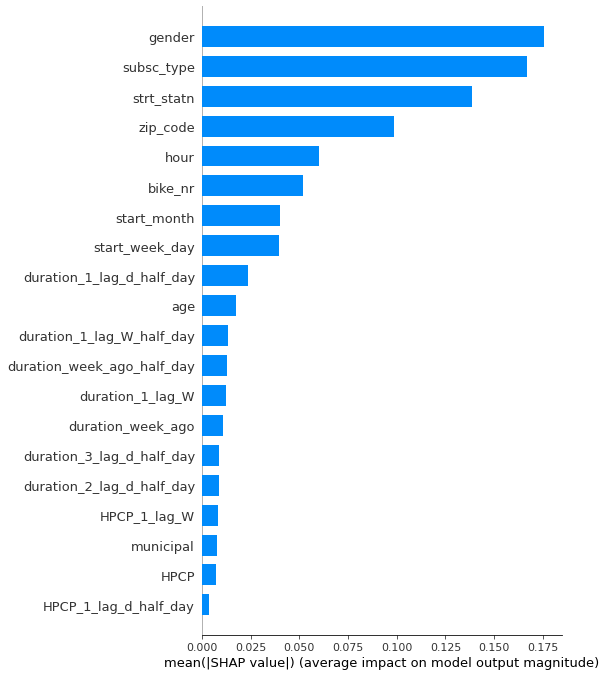

In [9]:
#get sample of data and check SHAP values
df_shaps = X.sample(10000)
df_shaps
shap_values = shap.TreeExplainer(lgbm).shap_values(df_shaps)
shap.summary_plot(shap_values, df_shaps, plot_type='bar')

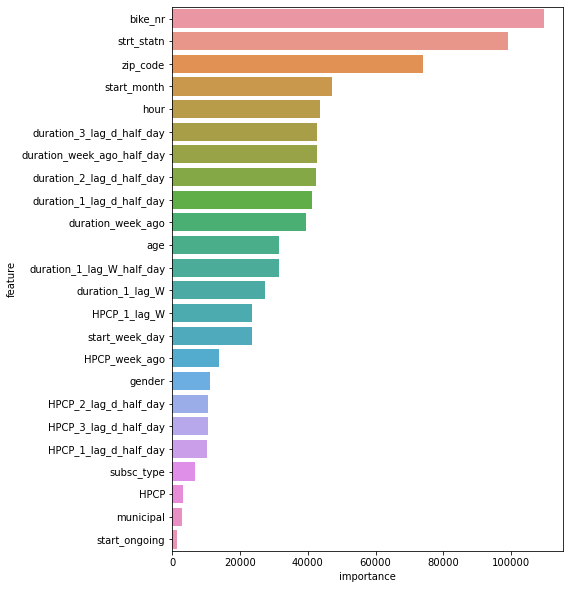

In [13]:
#check feature importances from lgbm
plt.figure(figsize=(7, 10))
df_importances = pd.DataFrame({"feature":X.columns.tolist(),"importance":lgbm.feature_importances_}).sort_values("importance",ascending = False)
ax = sns.barplot(x="importance", y='feature', data=df_importances)

### Alternative approach
##### data preparation example 

In [23]:
#alternative approach
# example of 
categorical_feats = [
             'strt_statn',
             'bike_nr',
             'subsc_type',
             'zip_code',
             'gender',
             'municipal',
             'half_of_day',
             'start_week_day',
             'age_bin',
             'start_month',
             'start_ongoing'
]

numerical_feats= [
             'HPCP',
             'hour',
]


wdh = HubwayTaskHelper()
data_lgbm = wdh.make_features()
data_ready = wdh.bin_age(data_lgbm)

#need to transform and scale all data
duration_pt = PowerTransformer()
sc = MinMaxScaler()
data_ready["duration"] = duration_pt.fit_transform(data_ready[["duration"]])
data_ready[["duration","hour"]] = sc.fit_transform(data_ready[["duration","hour"]])

for i in categorical_feats:
    le = LabelEncoder()
    sc = MinMaxScaler()
    data_ready[i] = data_ready[i].fillna('na')
    data_ready[i] = data_ready[i].astype(str)
    data_ready[i] = le.fit_transform(data_ready[[i]])
    data_ready[i] = sc.fit_transform(data_ready[[i]])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change th

##### example of data genarator
##### needs optimization!

In [26]:
import random
def _make_sample(df):
    non_seq_features = ['strt_statn',
     'bike_nr',
     'subsc_type',
     'zip_code',
     'gender',
     'municipal',
     'half_of_day',
     'start_week_day',
     'age_bin',
     'start_month',
     'start_ongoing',
     'HPCP',
     'hour',]
    row_num = random.randint(0, df.shape[0]-1)
    df["start_day"] = df["start_date"].dt.to_period('D')
    df_week = df[(df["start_day"] >= df.loc[row_num]["start_day"] + timedelta(days=-21)) & (df["start_day"]<df.loc[row_num]["start_day"]) & (df.loc[row_num]["municipal"] == df["municipal"])]
    df_seq = df_week.groupby(["start_day"])[["duration"]].mean().reset_index()
    if df_seq.shape[0]<21:
        end = df.loc[row_num]["start_day"] + timedelta(days=-21)
        df_dates = pd.DataFrame(pd.date_range(end.to_timestamp() ,periods=21, freq="D"), columns=["date"])
        df_dates["date"] = df_dates["date"].dt.to_period('D')
        df_dates=  df_dates.merge(df_seq, how = "left", left_on=["date"], right_on=["start_day"])
        df_dates["duration"] = df_dates["duration"].fillna(df_dates["duration"].mean())
        df_seq = df_dates
    df_seq = df_seq["duration"]+ 1.e-17
    df_non_seq = df.loc[row_num][non_seq_features]
    df_non_seq["HPCP"] = df_non_seq["HPCP"] + 1.e-17
    y= df.loc[row_num]["duration"] + 1.e-17
    return df_seq.values.reshape([1,21,1]), df_non_seq.values.reshape([1,13]), y.reshape(1,1)

def get_batches(df):
    while True:
        seq_batch_arrray = np.empty([1,21,1], "float32")
        non_seq_batch_arrray = np.empty([1,13], "float32")
        target_batch_array = np.empty([1,1], "float32")
        for i in range(63):
            seq, non_seq, target = _make_sample(df)
            seq_batch_arrray = np.append(seq_batch_arrray, seq,0)
            non_seq_batch_arrray = np.append(non_seq_batch_arrray, non_seq,0)
            target_batch_array = np.append(target_batch_array, target,0)
        yield [seq_batch_arrray.astype('float32'), non_seq_batch_arrray.astype('float32')], target_batch_array.astype('float32')

##### example of model 

In [ ]:
n_steps = df_saved.shape[0]/64
maxlen= 21
non_seq_features =13
seq_inp = Input(shape=(maxlen,1), name= "seq")
nonseq_inp = Input(shape=(non_seq_features,), name = "non_seq")
if lstm_layers >0:
    x = Bidirectional(LSTM(lstm_neurons, return_sequences=True, name ='lstmbase'))(seq_inp)
    x = Dropout(0.4, name="dropout_1")(x)

    for i in range(lstm_layers):
        x = Bidirectional(LSTM(lstm_neurons, return_sequences= i != lstm_layers-1, name= f'lstm{i}'))(x)
        x = Dropout(0.4,name= f'dropout{i}')(x)
else:
    x = Bidirectional(LSTM(lstm_neurons, return_sequences=False, name ='lstmbase'))(seq_inp)
    x = Dropout(0.4, name="dropout_1")(x)
x = concatenate([x, nonseq_inp], name = "concatenate")
x = Dense(dense_neurons, activation="relu")(x)
x = Dropout(0.4)(x)
out = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[seq_inp, nonseq_inp], outputs=out)

decay = lr/n_steps
optimizer = Adam(lr=lr, decay=decay,clipnorm=1.)
model.compile(loss='mse', optimizer=optimizer)
model.fit_generator(get_batches(data_ready), epochs=200, steps_per_epoch=100)

model.save(os.path.join(model_dir, 'model'))
print ("DONE model saved to ",os.path.join(model_dir, 'model'))